# Importing necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [ ]:
np.random.seed(42)

In [ ]:
#from google.colab import drive
#drive.mount(r'/content/drive/')

# Parameters of simulation

In [ ]:
KbT = 2
beta = 1/KbT
N = 10 #number of particles
P = np.arange(5,300,5)  # pressures
sigma = 1   #2*radius of particles
cutoff = 3 * sigma  # LJ cutoff
epsilon = 1 # LJ epsilon
displacement_size = 0.1   # max particle displacement during a move
logVolumeChange = 0.05   #max log(Volume) change during a move
h = 1   # planck's constant
m = 1   # mass of particle
Lambda = h/(2*np.pi*m*KbT)**0.5   #De Broglie's thermal wavelength

In [ ]:
P.size #number of pressure values

59

In [ ]:
Lambda

0.28209479177387814

# Defining useful functions

In [ ]:
def calc_LJ(r):  # calculates L-J potential
  "returns array containing parts of LJ potential corresponding to different exponent of r(radial distance)"
  if r > cutoff:
    return np.array([0.0,0.0])
  r6 = (sigma / r)**6
  r12 = r6**2
  return np.array([4 * epsilon * r12 , 4 * epsilon * r6])

In [ ]:
def calc_TotPE(system, box_length, pbc=True):
  final = np.array([0.0,0.0])
  for i in range(N):
    for j in range(i+1, N):
      rij = system[i] - system[j]
      if (pbc):
        rij = np.abs(rij)
        rij = np.minimum(rij, box_length - rij)
      r = np.linalg.norm(rij)
      final += calc_LJ(r)
  return final

In [ ]:
a = np.array([1, 2, 3])
b = np.array([3, 2, 1])
np.minimum(a, b)

array([1, 2, 1])

In [ ]:
def mcmove(system, box_length, pbc=True):
  "Does a single particle displacement Monte Carlo move"
  index = np.random.randint(N) #random particle
  move = (np.random.rand(3)-0.5)*displacement_size #random move
  new_pos = system[index] + move ; old_pos = system[index]
  if (pbc): new_pos = new_pos % box_length
  deltaE = np.array([0.0,0.0])  #change in energies(corresponding to different powers of r)
  for i in range(N):
    if i != index:
      riin_old = old_pos - system[i]
      riin_new = new_pos - system[i]
      if (pbc):
        riin_old = np.abs(riin_old)
        riin_new = np.abs(riin_new)
        riin_old = np.minimum(riin_old, box_length - riin_old)
        riin_new = np.minimum(riin_new, box_length - riin_new)
      r_old = np.linalg.norm(riin_old)
      r_new = np.linalg.norm(riin_new)
      deltaE += calc_LJ(r_new)
      deltaE -= calc_LJ(r_old)
  arg = -beta * (deltaE[0]-deltaE[1])  # boltzmann factor for net energy change
  if (np.log(np.random.uniform(1e-20, 1)) < arg): #move accepted
    system[index] = new_pos
    return system,deltaE,1  # 1 is scale factor of system dimensions
  else: #move rejected
    return system,np.array([0,0]),1 # 1 is scale factor of system dimensions

In [ ]:
def mcvol(system,old_box_length,oldE,P): # P is pressure
  "Does a single volume change Monte Carlo move"
  old_vol = old_box_length**3
  move = np.log(old_vol) + (np.random.rand()-0.5)*logVolumeChange
  new_vol = np.exp(move)
  new_box_length = new_vol**(1/3)
  scale = new_box_length/old_box_length
  scale3 = scale**3; scale6=scale3**2; scale12=scale6**2
  newE = np.array([oldE[0]/(scale12),oldE[1]/(scale6) ])
  deltaE = newE-oldE ; dE = deltaE[0]-deltaE[1]
  arg = (-beta * (dE+P*(new_vol-old_vol)) + (N+1)*np.log(scale3))
  if (np.log(np.random.uniform(1e-20,1)) < arg):   # move accepted
    system *= scale
    return system,deltaE,scale
  else: # move rejected
    return system,np.array([0,0]),1

In [ ]:
def NPTmove(system,old_box_length,oldE,P):
  if (np.random.randint(1,N+1)==N): # volume change with P=1/N
    system,deltaE,scale = mcvol(system,old_box_length,oldE,P)
  else: # particle displacement
    system,deltaE,scale = mcmove(system,old_box_length)

  return system,deltaE,scale

In [ ]:
def calc_MuEx(system,box_length,E,P,pbc=True):
    # Initialize a list to store Boltzmann factors for each sample
    boltzmann_factors = []
    system = system.copy(); E = E.copy()  # copying systems so that actual system is not changed

    for iter in range(2000):  # 2000 samples for averaging

        # Generate a random position for the additional particle
        new_position = np.random.rand(3) * box_length

        # Do a montecarlo step
        system,deltaE,scale = NPTmove(system,box_length,E,P)
        E+=deltaE ; box_length*=scale

        # Calculate the energy difference ΔU if we add a particle at this position
        dE = 0
        for i in range(N): # calculate particle addition energy
            rij = system[i] - new_position
            if (pbc):
                rij = np.abs(rij)
                rij = np.minimum(rij, box_length - rij)
            r = np.linalg.norm(rij)
            LJenergy = calc_LJ(r)
            dE += LJenergy[0] - LJenergy[1]

        # Calculate the Boltzmann factor for this sample
        boltzmann_factors.append(np.exp(-beta * dE))


    avg_boltzmann_factor = np.mean(boltzmann_factors) + 1e-40

    # Calculate the excess chemical potential
    mu_ex = -KbT * np.log(avg_boltzmann_factor)
    return mu_ex

# Initialisation

In [ ]:
box_length = np.ones(P.size)*5 # square box of 5 units length

In [ ]:
# initially volume fraction is same for all systems and thus at same pressure
occupied_vol = N*((4*np.pi*((0.5*sigma)**3)) / 3)
phi = np.array([occupied_vol/(box_length[i]**3) for i in range(P.size)])

In [ ]:
phi[0] # initial phi

0.041887902047863905

In [ ]:
systems = np.random.rand(P.size,N,3)*box_length[0]
energies = np.array([calc_TotPE(systems[i],box_length[i]) for i in range(P.size)])

# Transitions

In [ ]:
iter1 = 2000 ; energyVSiter1 = np.zeros((P.size,iter1))
for i in range(P.size):
  for j in range(iter1):
    systems[i],dE,scale = mcmove(systems[i],box_length[i])
    energies[i] += dE
    energyVSiter1[i,j] = energies[i][0]-energies[i][1]

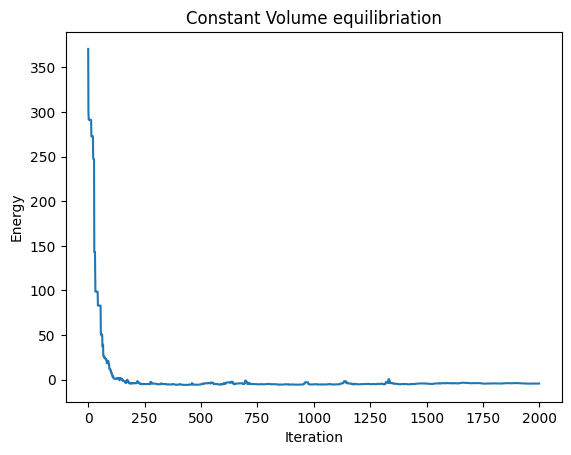

In [ ]:
plt.plot(np.linspace(0,1999,2000),energyVSiter1[2][:])
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Constant Volume equilibriation')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/NVT_eq.png')
plt.show()

In [ ]:
iter2 = 8000 ; iter3 = 2000
energyVSiter2 = np.zeros((P.size,iter2))
phi_record = np.zeros((P.size,iter2+iter3))
for i in range(P.size):
  for j in range(iter2):
    systems[i],dE,scale = NPTmove(systems[i],box_length[i],energies[i],P[i])
    energies[i] += dE
    box_length[i] *= scale
    energyVSiter2[i,j] = energies[i][0]-energies[i][1]
    phi[i] = occupied_vol/(box_length[i]**3)
    phi_record[i,j] = phi[i]

In [ ]:
for iter in range(P.size):
  plt.plot(energyVSiter2[iter][:])
  plt.xlabel('Iteration')
  plt.ylabel('Energy')
  plt.title(f'Energy vs Iter (equilibriation at P={P[iter]})')
  plt.savefig(f'//content//drive//MyDrive//Colab Notebooks//pyl435_assgn3//NPT_equilibriation//NPT_eq_P{P[iter]}.png')
  plt.show()
  plt.clf()

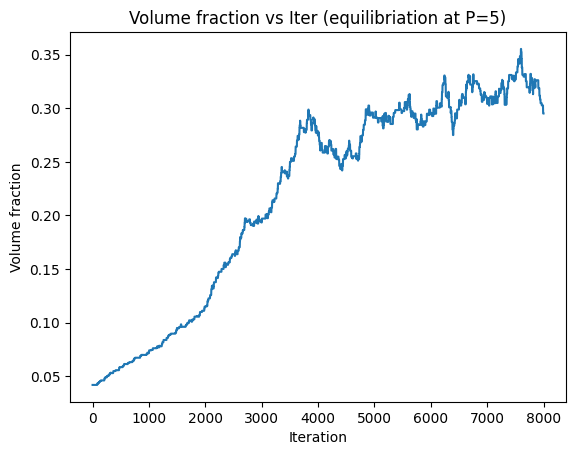

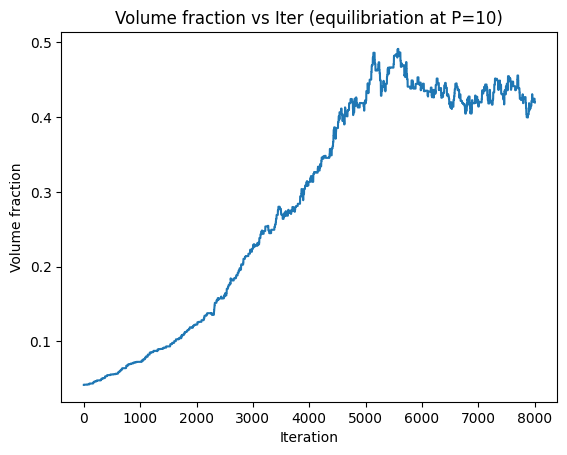

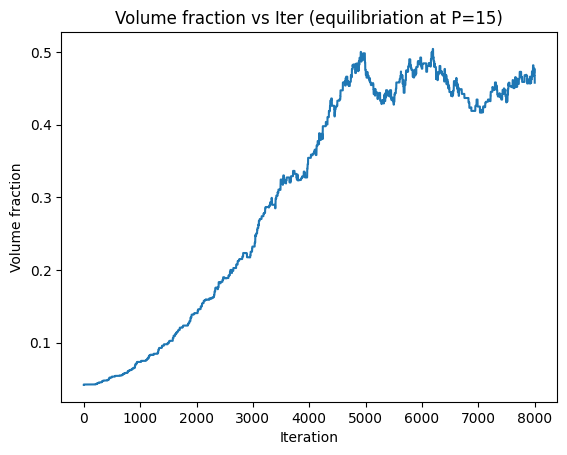

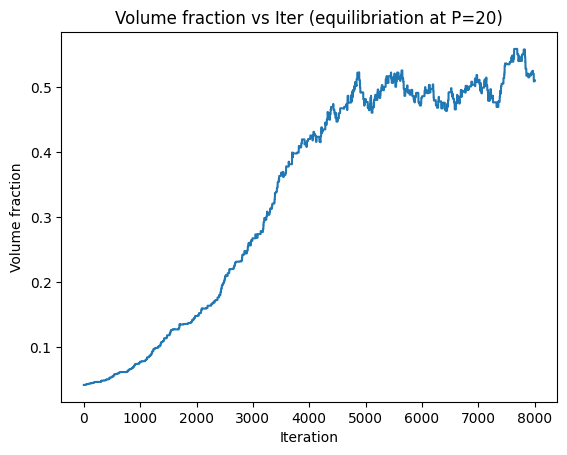

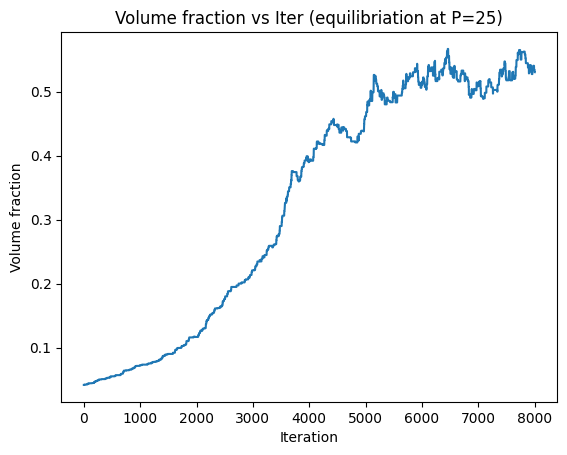

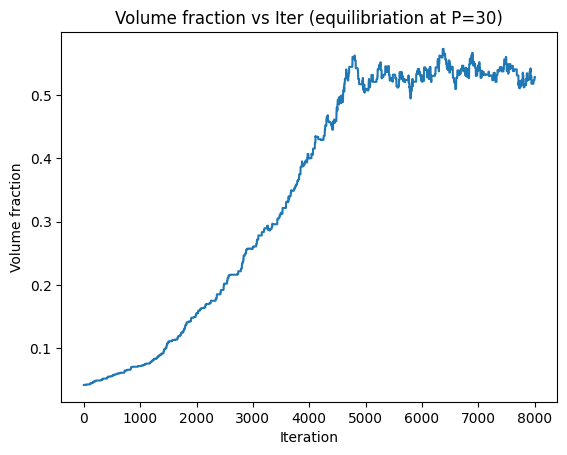

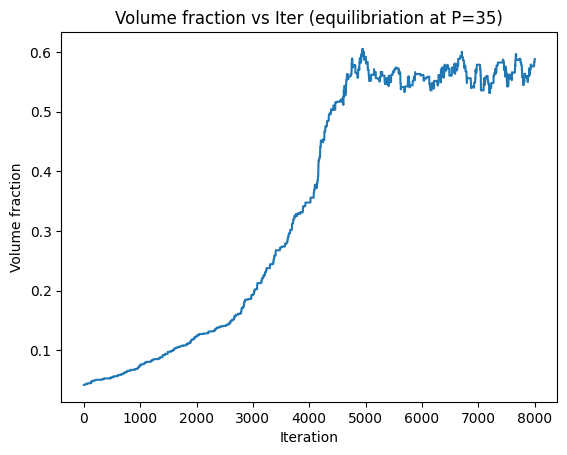

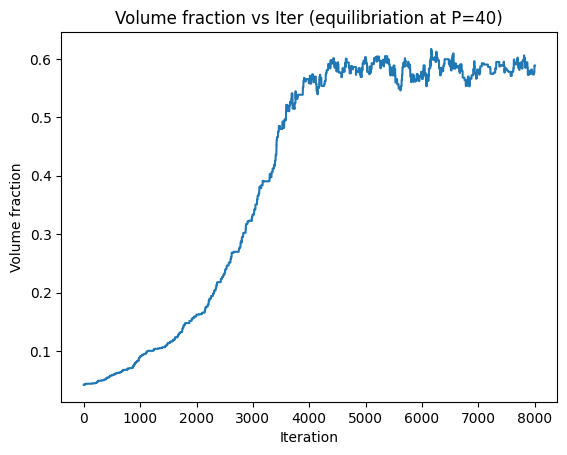

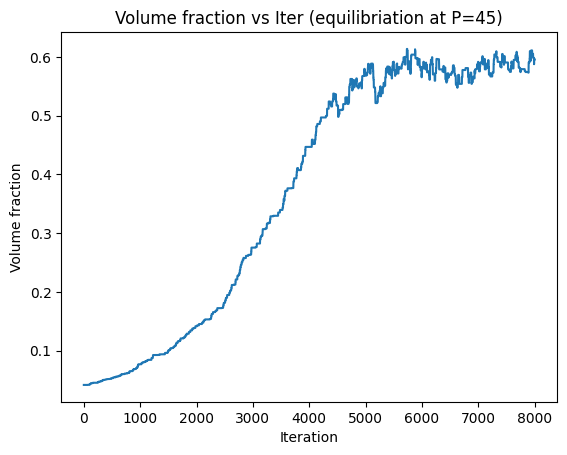

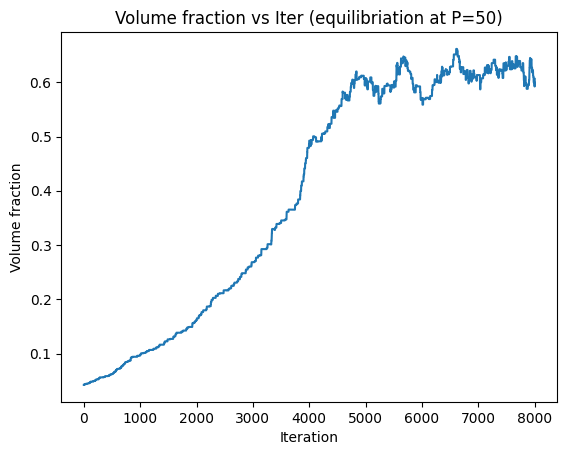

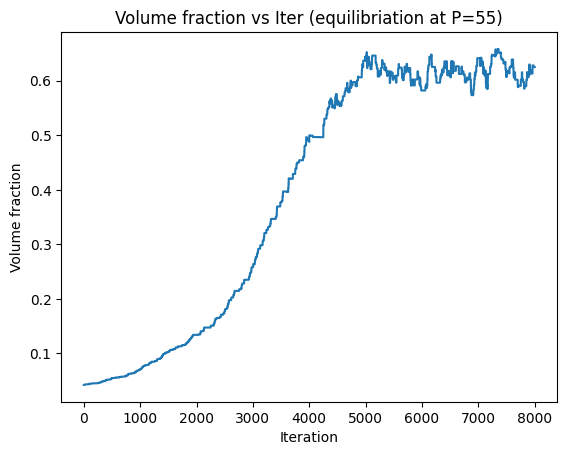

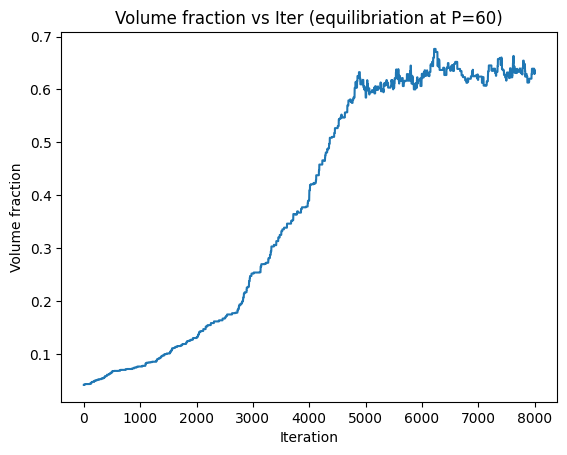

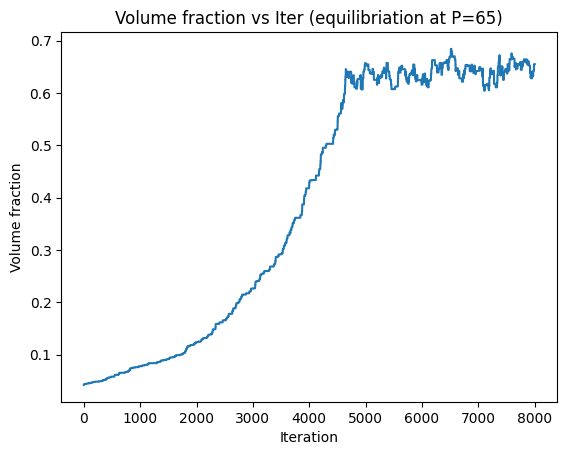

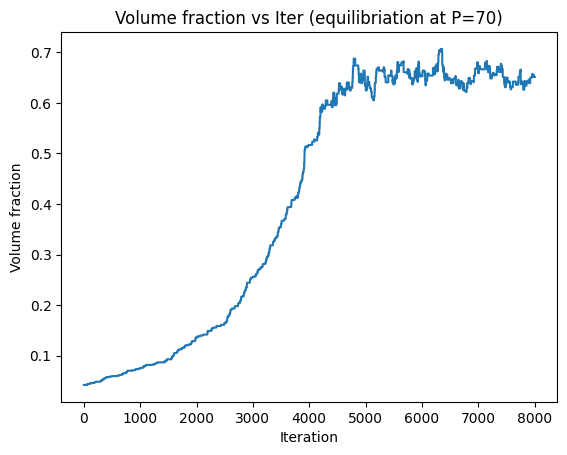

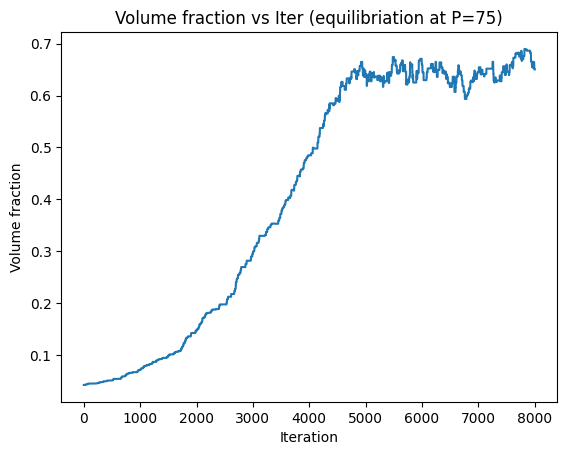

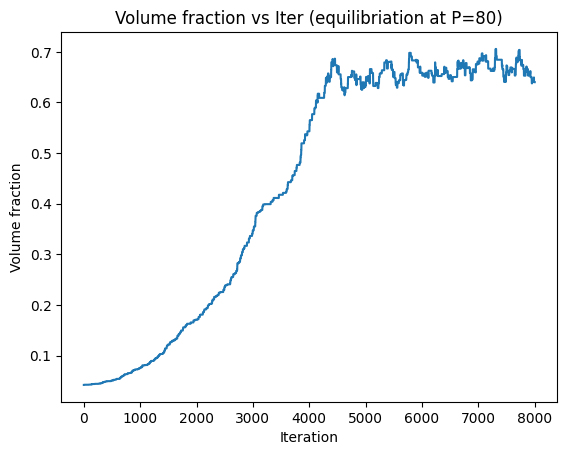

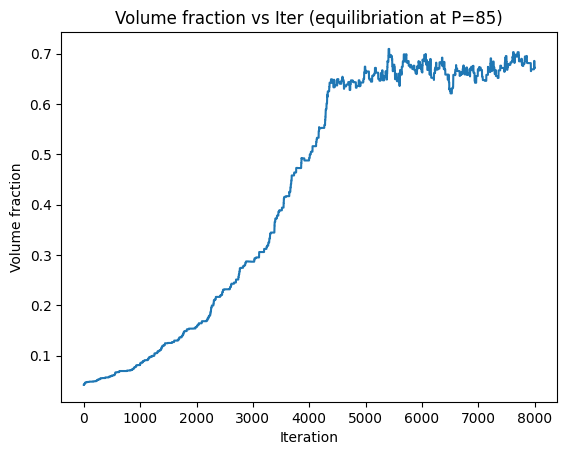

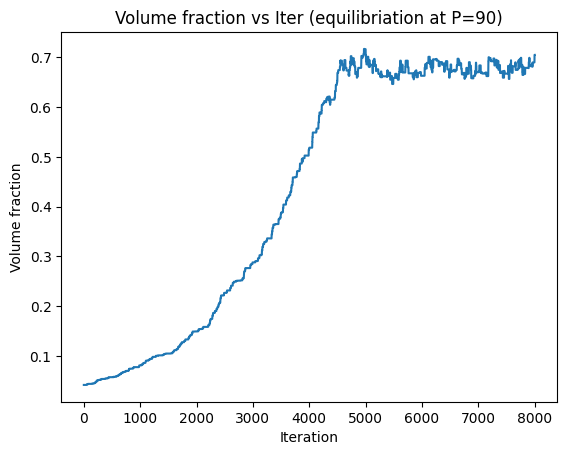

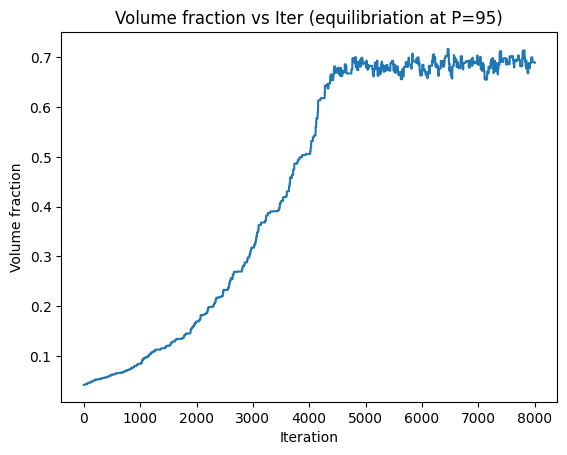

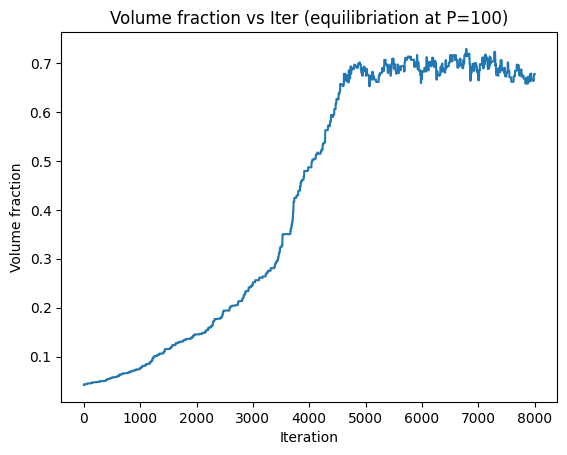

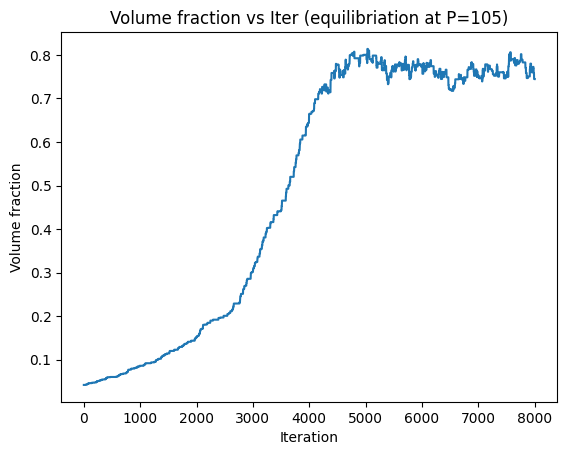

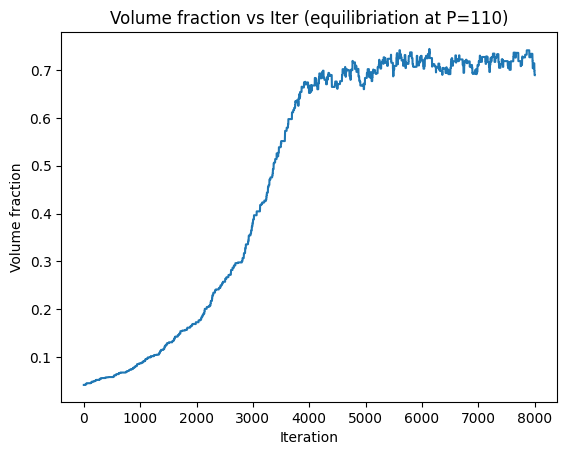

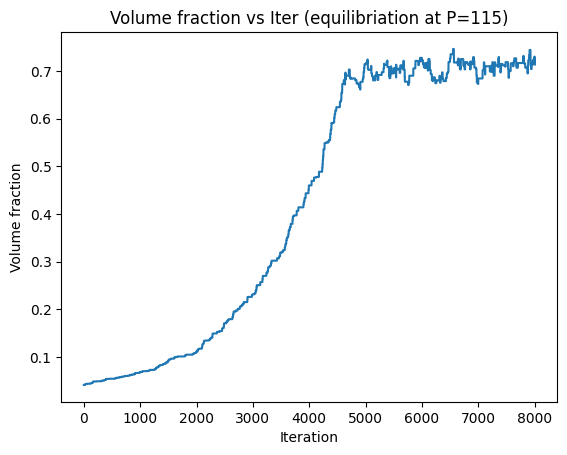

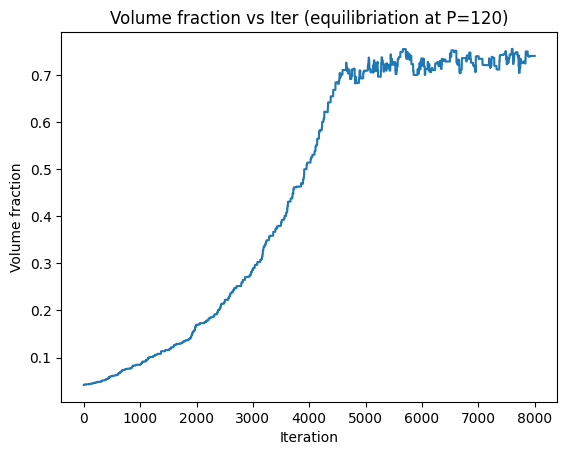

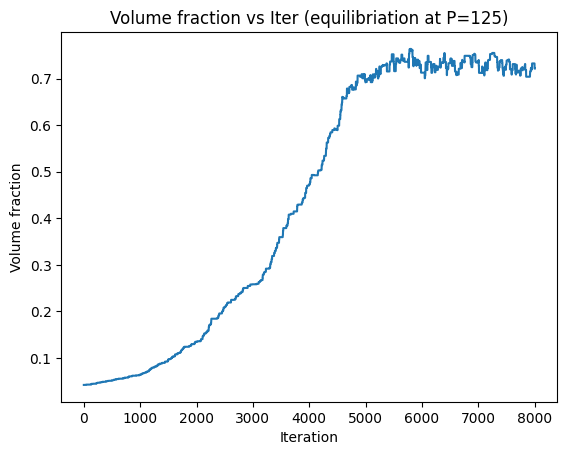

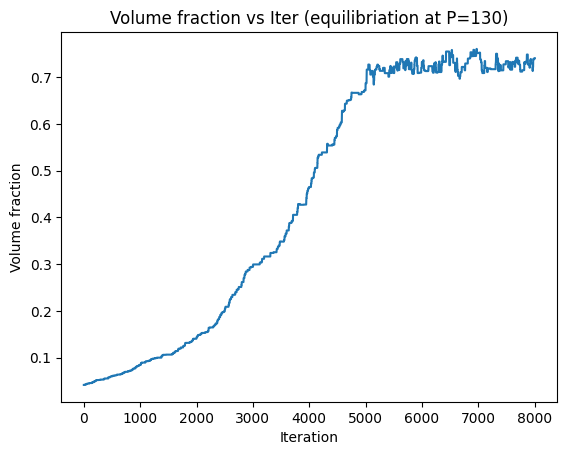

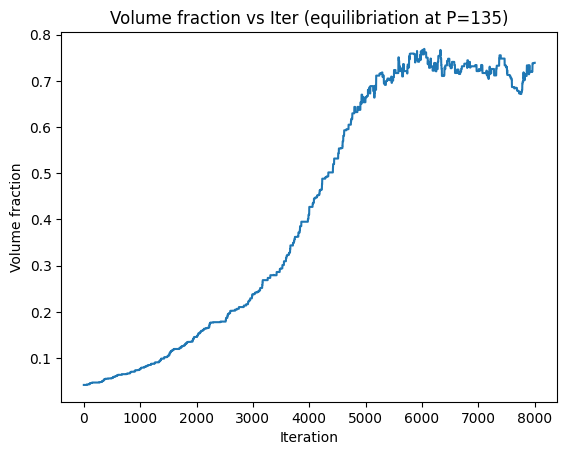

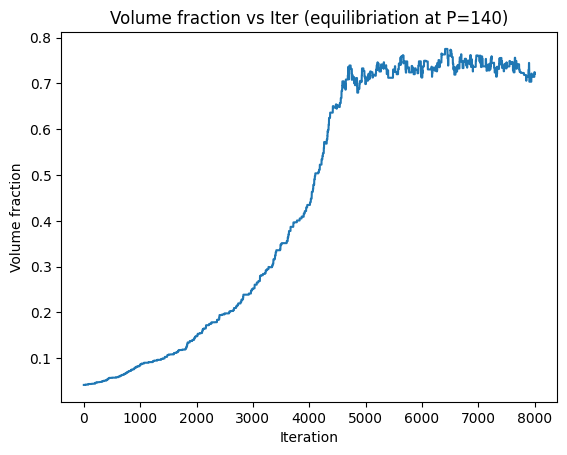

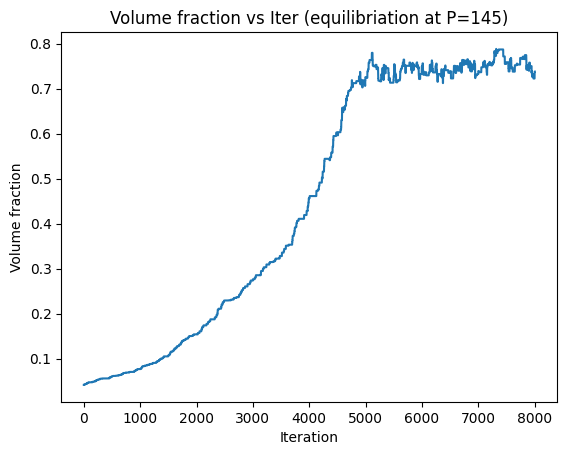

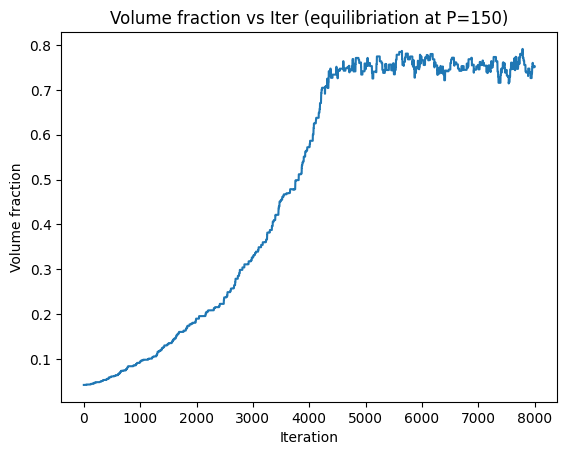

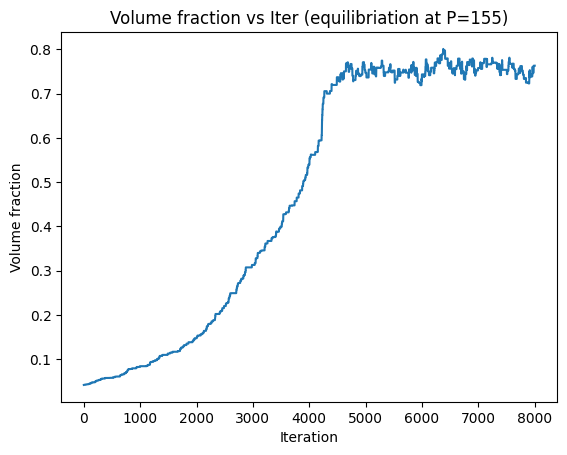

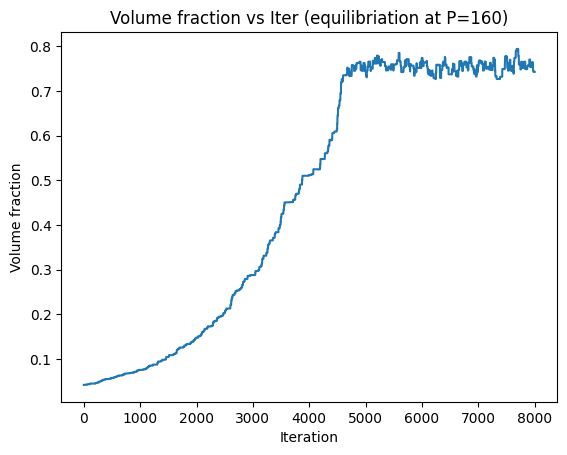

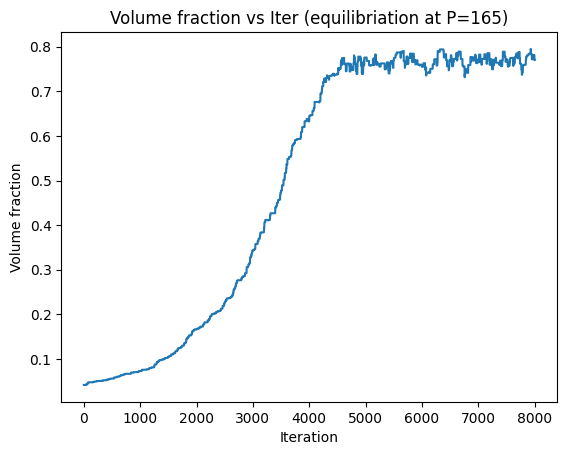

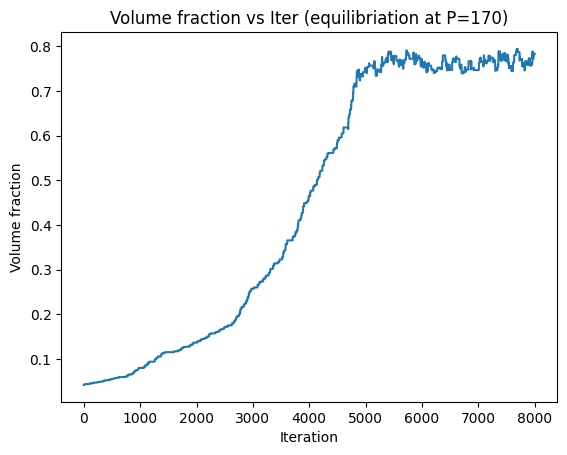

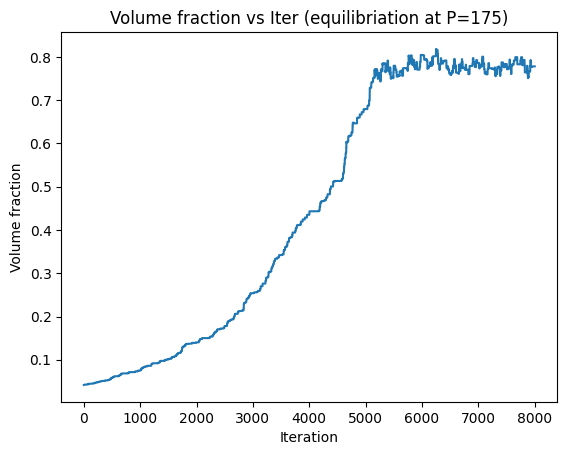

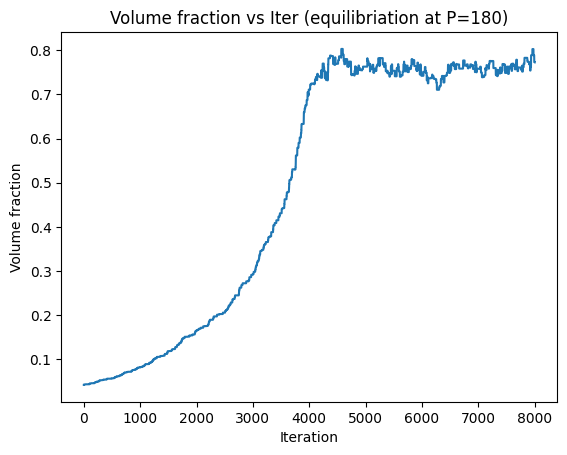

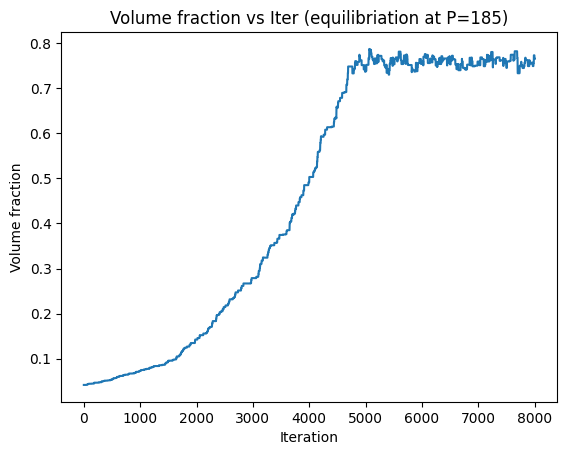

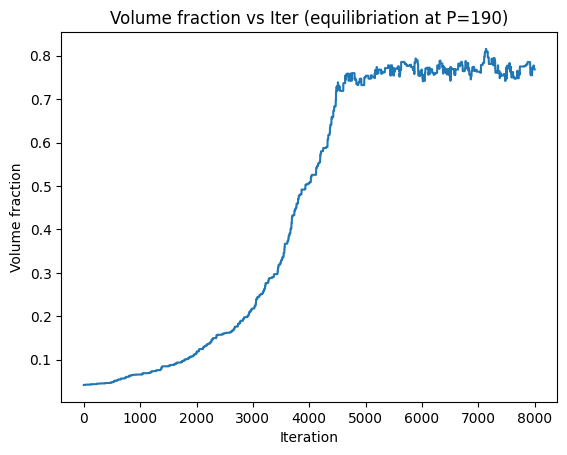

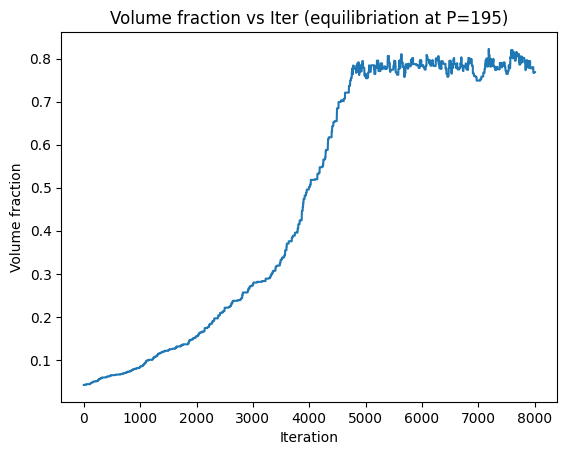

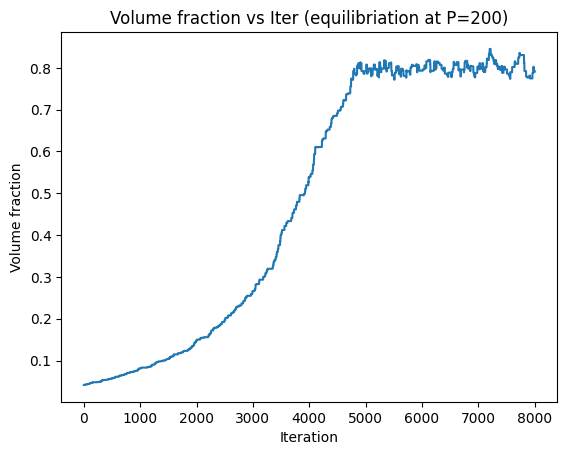

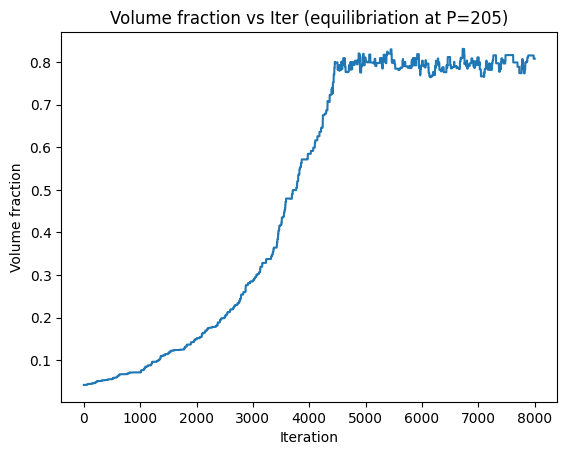

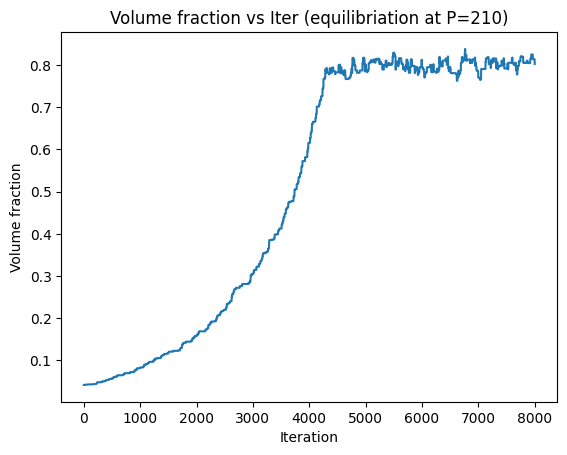

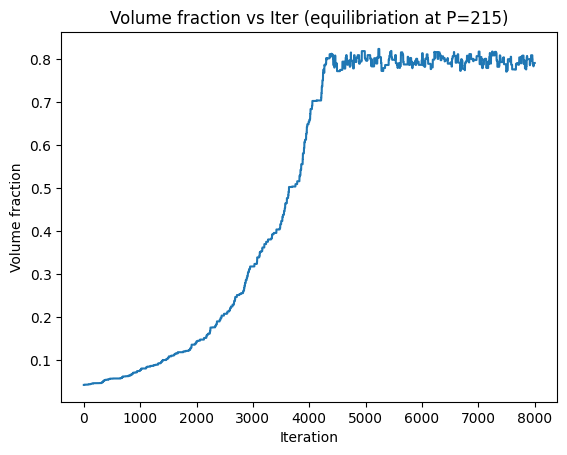

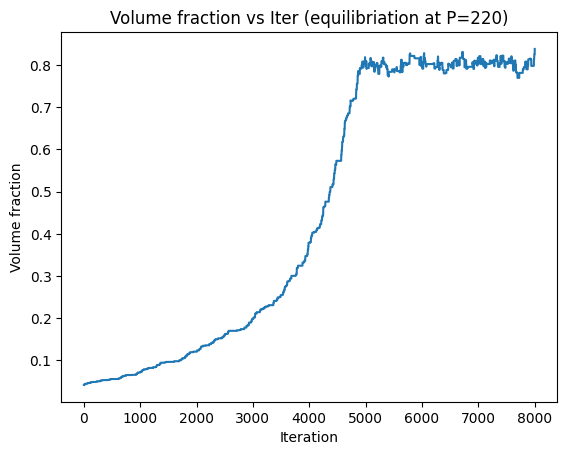

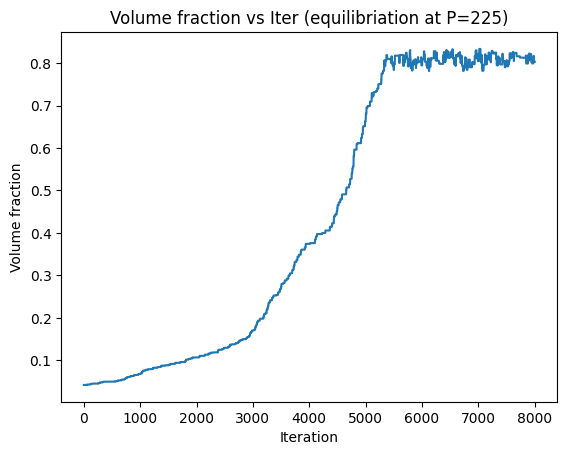

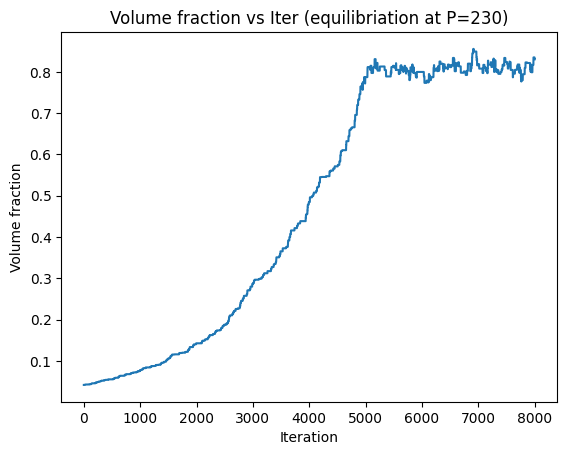

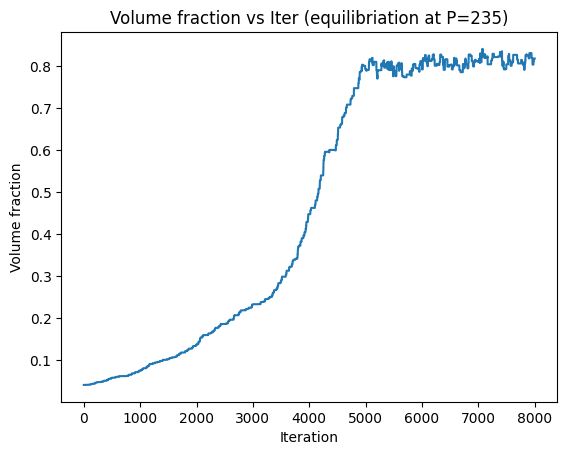

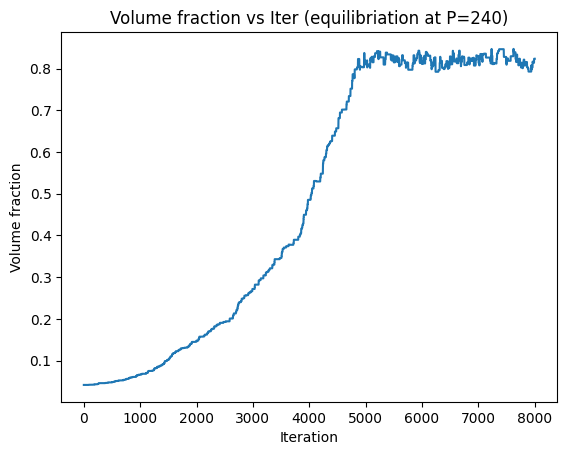

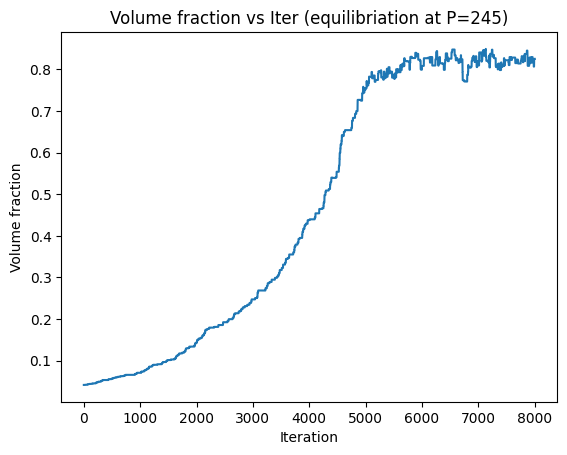

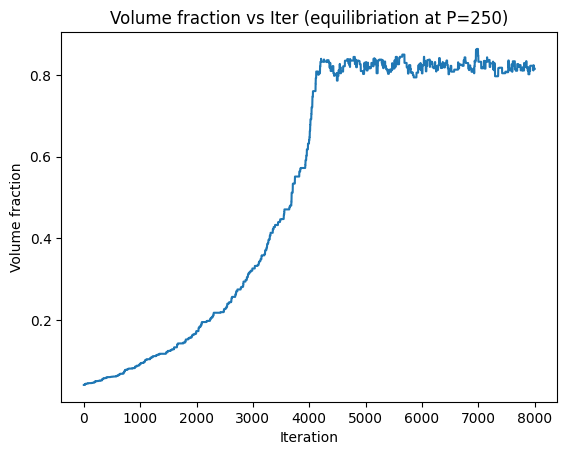

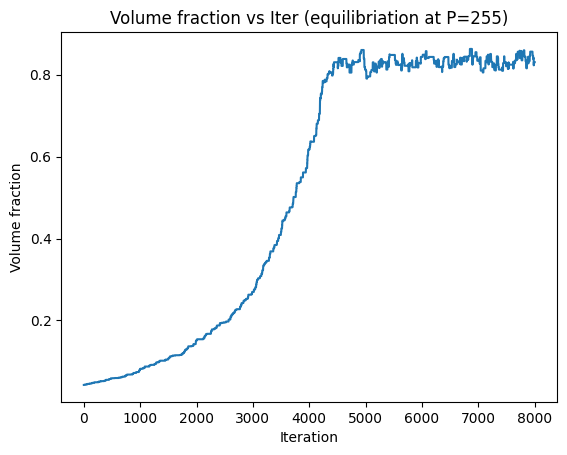

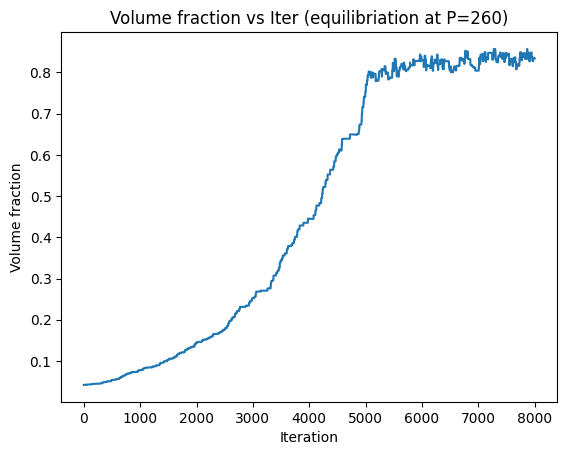

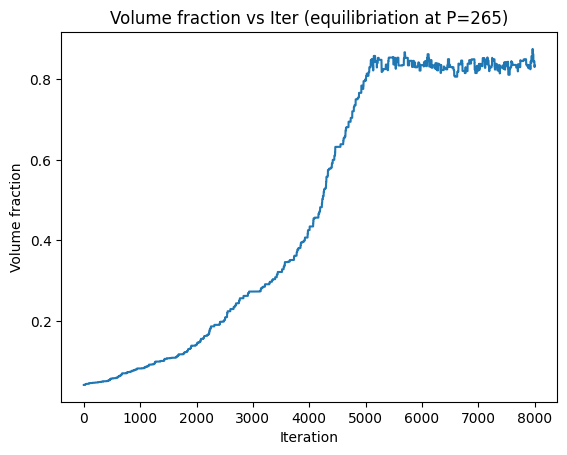

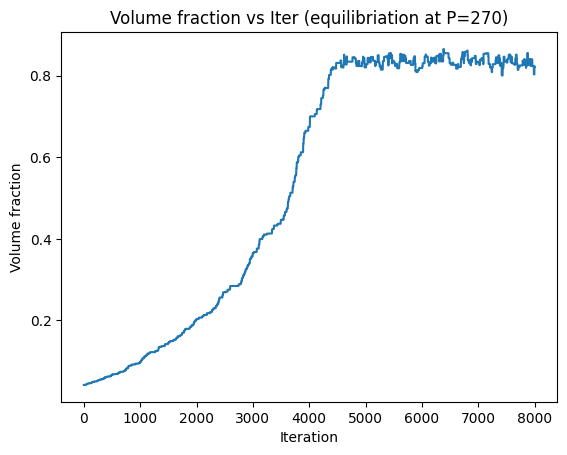

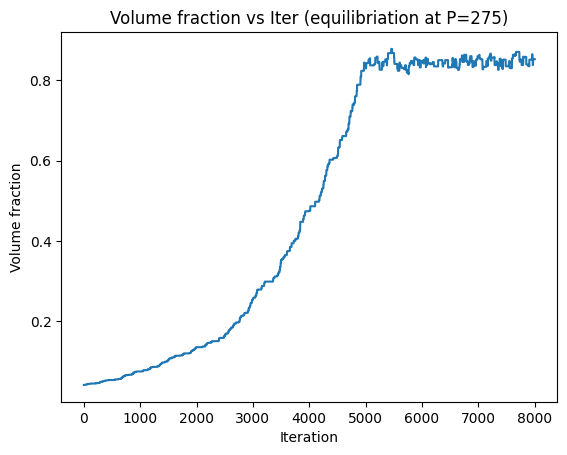

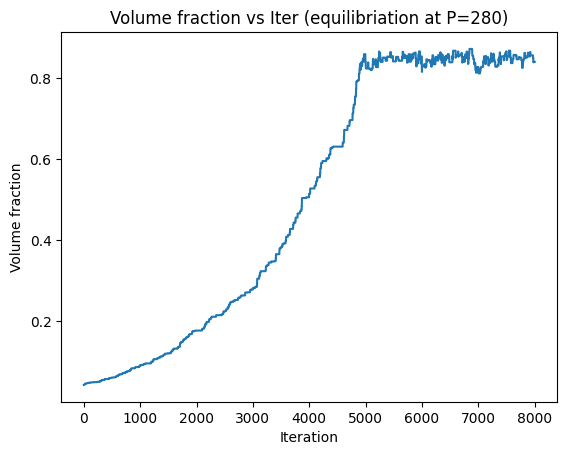

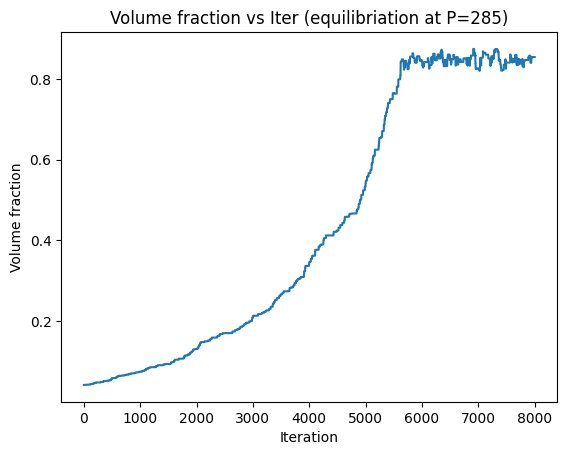

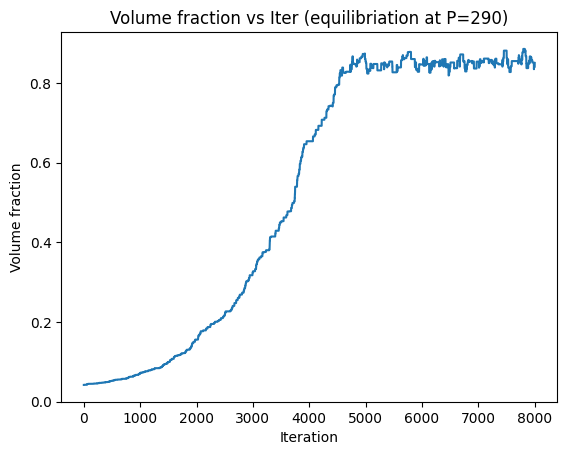

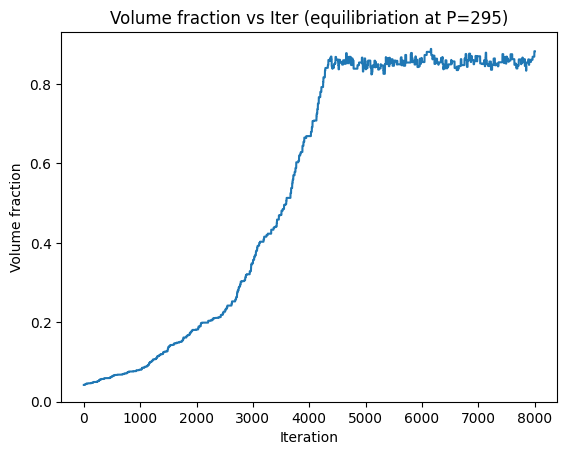

<Figure size 640x480 with 0 Axes>

In [ ]:
for iter in range(P.size):
  plt.plot(phi_record[iter][:iter2])
  plt.xlabel('Iteration')
  plt.ylabel('Volume fraction')
  plt.title(f'Volume fraction vs Iter (equilibriation at P={P[iter]})')
  plt.savefig(f'//content//drive//MyDrive//Colab Notebooks//pyl435_assgn3//NPT_eq_phi//NPT_eq_phi_P{P[iter]}.png')
  plt.show()
  plt.clf()

# Calculating mean densities and mean energies at different applied pressures and plotting it against pressure

In [ ]:
# sampling volume fractions and energies
energyVSiter3 = np.zeros((P.size,iter3))
for i in range(P.size):
  for j in range(iter3):
    systems[i],dE,scale = NPTmove(systems[i],box_length[i],energies[i],P[i])
    energies[i] += dE
    box_length[i] *= scale
    #energyVSiter2[i,j] = energies[i][0]-energies[i][1]
    phi[i] /= scale**3
    phi_record[i,iter2+j] = phi[i]
    energyVSiter3[i,j] = energies[i][0]-energies[i][1]

In [ ]:
phi_mean = np.array([np.mean(phi_record[i,iter2:iter2+iter3]) for i in range(P.size)])

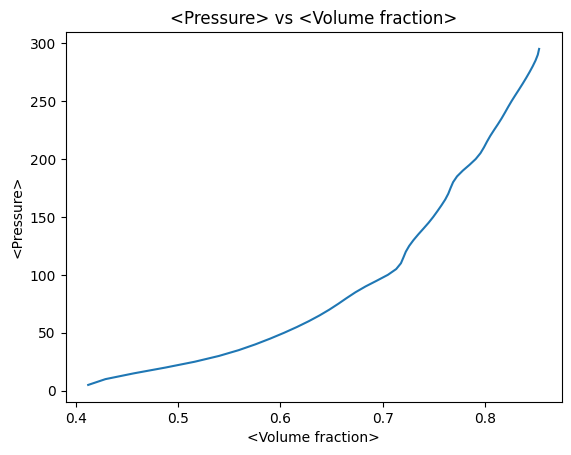

In [ ]:
mask = phi_mean<1
plt.plot(gaussian_filter(phi_mean[mask],2),P[mask])
plt.xlabel('<Volume fraction>')
plt.ylabel('<Pressure>')
plt.title('<Pressure> vs <Volume fraction>')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/phi_vs_P.png')
plt.show()

In [ ]:
E_mean = np.array([np.mean(energyVSiter3[i,:]) for i in range(P.size)])

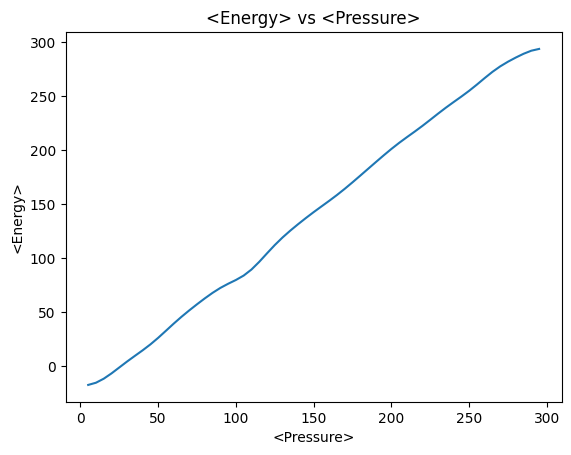

In [ ]:
plt.plot(P[mask],gaussian_filter(E_mean[mask],2))
plt.ylabel('<Energy>')
plt.xlabel('<Pressure>')
plt.title('<Energy> vs <Pressure>')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/E_vs_P.png')
plt.show()

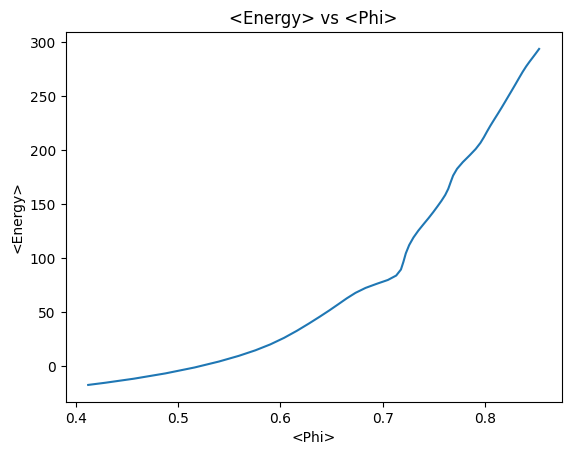

In [ ]:
plt.plot(gaussian_filter(phi_mean[mask],2),gaussian_filter(E_mean[mask],2))
plt.ylabel('<Energy>')
plt.xlabel('<Phi>')
plt.title('<Energy> vs <Phi>')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/E_vs_Phi.png')
plt.show()

# Calculate chemical potential

In [ ]:
mu_id = KbT*np.log(Lambda**3 * (N/box_length**3))
mu_ex = np.array([calc_MuEx(systems[i],box_length[i],energies[i],P[i]) for i in range(P.size)])
#for iter in range(P.size):
  #np.random.seed(42)  # random number generator reset
#  mu_ex[iter] = calc_MuEx(systems[i],box_length[i],energies[i],P[i])
mu = mu_ex + mu_id

# Chemical potential vs Pressure

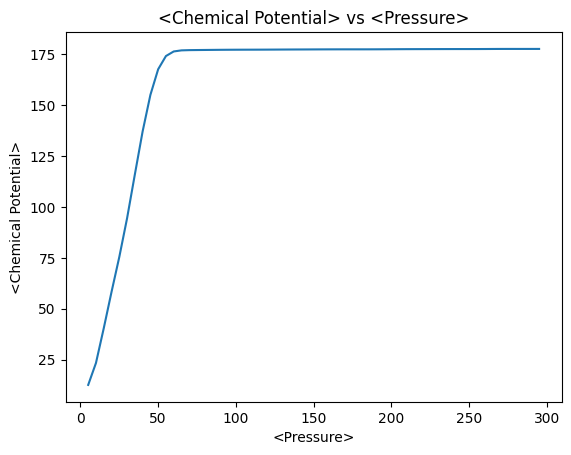

In [ ]:
plt.plot(P[mask],gaussian_filter(mu[mask],1.5))
plt.xlabel('<Pressure>')
plt.ylabel('<Chemical Potential>')
plt.title('<Chemical Potential> vs <Pressure>')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/mu_vs_P.png')
plt.show()

# Chemical potential vs volume fraction

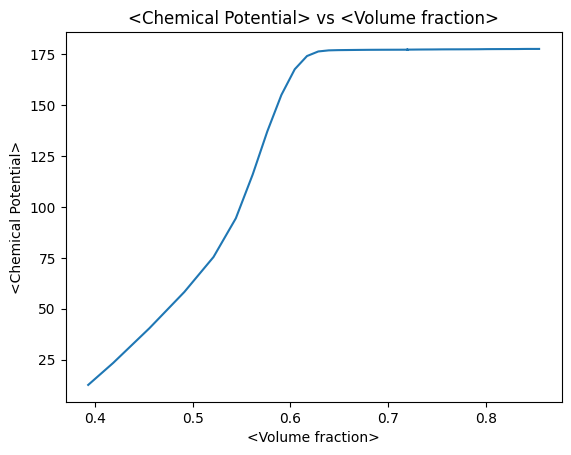

In [ ]:
plt.plot(gaussian_filter(phi_mean[mask],1.5),gaussian_filter(mu[mask],1.5))
plt.xlabel('<Volume fraction>')
plt.ylabel('<Chemical Potential>')
plt.title('<Chemical Potential> vs <Volume fraction>')
plt.savefig(r'/content/drive/MyDrive/Colab Notebooks/pyl435_assgn3/mu_vs_phi.png')
plt.show()

In [ ]:
#
#
#
#
#
#
#         IT ENDS HERE